# Practice reference
https://medium.com/datadriveninvestor/creating-a-pytorch-image-classifier-da9db139ba80

- env: Colab Notebook
- time: 2019-01-07

# Set up in Colab Notebook

In [0]:
# import PyTorch if using Google Colab
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'
!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

In [5]:
# train on gpu
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('Bummer!  Training on CPU ...')
else:
    print('You are good to go!  Training on GPU ...')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

You are good to go!  Training on GPU ...


In [7]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


# get data from URL and download to the left 

In [0]:
!wget -cq https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip
!unzip -qq flower_data.zip

In [0]:
# Import resources
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import time
import json
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import PIL
from PIL import Image
from collections import OrderedDict
import torch
from torch import nn, optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
import os

In [0]:
data_dir = '../content/flower_data'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'

In [0]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ])
}

# TODO: Load the datasets with ImageFolder: data type as one folder to save one label
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'valid']}
# TODO: Using the image datasets and the trainforms, define the dataloaders
batch_size = 128
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) 
              for x in ['train', 'valid']}
class_names = image_datasets['train'].classes
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes

In [13]:
# upload the cat_to_name.json to the left
with open('../content/cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)
    
images, labels = next(iter(dataloaders['train']))
images.size()
images, labels = next(iter(dataloaders['train']))
rand_idx = np.random.randint(len(images))
print("label: {}, class: {}, name: {}".format(labels[rand_idx].item(),
                                               class_names[labels[rand_idx].item()],
                                               cat_to_name[class_names[labels[rand_idx].item()]]))

label: 43, class: 46, name: wallflower


# use pre-trained model from pytorch

In [20]:
model_name = 'vgg' 
if model_name == 'densenet':
    model = models.densenet161(pretrained=True)
    num_in_features = 2208
    print(model)
elif model_name == 'vgg':
    model = models.vgg19(pretrained=True)
    num_in_features = 25088
    print(model.classifier)
else:
    print("Unknown model, please choose 'densenet' or 'vgg'")

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace)
  (2): Dropout(p=0.5)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace)
  (5): Dropout(p=0.5)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)


In [0]:
# Create classifier
for param in model.parameters():
    param.requires_grad = False
    
def build_classifier(num_in_features, hidden_layers, num_out_features):
   
    classifier = nn.Sequential()
    if hidden_layers == None:
        classifier.add_module('fc0', nn.Linear(num_in_features, 102))
    else:
        layer_sizes = zip(hidden_layers[:-1], hidden_layers[1:])
        classifier.add_module('fc0', nn.Linear(num_in_features, hidden_layers[0]))
        classifier.add_module('relu0', nn.ReLU())
        classifier.add_module('drop0', nn.Dropout(0.2))

        for i, (h1, h2) in enumerate(layer_sizes):
            classifier.add_module('fc'+str(i+1), nn.Linear(h1, h2))
            classifier.add_module('relu'+str(i+1), nn.ReLU())
            classifier.add_module('drop'+str(i+1), nn.Dropout(.5))
        classifier.add_module('output', nn.Linear(hidden_layers[-1], num_out_features))
        
    return classifier

In [22]:
# hidden_layers = (128, 64)
classifier = build_classifier(num_in_features, None, 102)
print(classifier)
if model_name == 'densenet':
    model.classifier = classifier
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
elif model_name == 'vgg':
    model.classifier = classifier
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
else:
    pass

Sequential(
  (fc0): Linear(in_features=25088, out_features=102, bias=True)
)


In [23]:
def train_model(model, criterion, optimizer, num_epochs):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)
        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
          
            running_loss = 0.0
            running_corrects = 0
        
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
            
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()
      
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    #load best model weights
    model.load_state_dict(best_model_wts)
    
    return model
  
  

epochs = 6
model.to(device)
model = train_model(model, criterion, optimizer, epochs)

Epoch 1/6
----------
train Loss: 3.2867 Acc: 0.3060
valid Loss: 1.7371 Acc: 0.6320

Epoch 2/6
----------
train Loss: 1.7704 Acc: 0.6221
valid Loss: 1.0777 Acc: 0.7775

Epoch 3/6
----------
train Loss: 1.2983 Acc: 0.7387
valid Loss: 0.8260 Acc: 0.8240

Epoch 4/6
----------
train Loss: 1.0879 Acc: 0.7738
valid Loss: 0.6988 Acc: 0.8606

Epoch 5/6
----------
train Loss: 0.9480 Acc: 0.8057
valid Loss: 0.6197 Acc: 0.8667

Epoch 6/6
----------
train Loss: 0.8582 Acc: 0.8141
valid Loss: 0.5586 Acc: 0.8692

Training complete in 12m 33s
Best val Acc: 0.869193


In [24]:
model.eval()
accuracy = 0
for inputs, labels in dataloaders['valid']:
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)
    
    # Class with the highest probability is our predicted class
    equality = (labels.data == outputs.max(1)[1])
# Accuracy is number of correct predictions divided by all predictions
    accuracy += equality.type_as(torch.FloatTensor()).mean()
    
print("Test accuracy: {:.3f}".format(accuracy/len(dataloaders['valid'])))

Test accuracy: 0.872


In [0]:
path = "/content/gdrive/My Drive/Colab Notebooks/"
model.class_to_idx = image_datasets['train'].class_to_idx
checkpoint = {'input_size': 25088,
              'output_size': 102,
              'epochs': epochs,
              'batch_size': 128,
              'model': models.vgg19(pretrained=True),
              'classifier': classifier,
              'optimizer': optimizer.state_dict(),
              'state_dict': model.state_dict(),
              'class_to_idx': model.class_to_idx
             }
   
torch.save(checkpoint, path+'checkpoint.pth')

In [27]:
ckpt = torch.load(path + 'checkpoint.pth')
ckpt.keys()

dict_keys(['input_size', 'output_size', 'epochs', 'batch_size', 'model', 'classifier', 'optimizer', 'state_dict', 'class_to_idx'])

In [0]:
image_size = 224
# Values you used for normalizing the images. Default here are for
# pretrained models from torchvision.
norm_mean = [0.485, 0.456, 0.406]
norm_std = [0.229, 0.224, 0.225]

In [0]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint['model']
    model.classifier = checkpoint['classifier']
    model.load_state_dict(checkpoint['state_dict'])
    model.class_to_idx = checkpoint['class_to_idx']
    optimizer = checkpoint['optimizer']
    epochs = checkpoint['epochs']
    
    for param in model.parameters():
        param.requires_grad = False
        
    return model, checkpoint['class_to_idx']
model, class_to_idx = load_checkpoint(path+'checkpoint.pth')

# Test

In [0]:
image_path = 'flower_data/valid/102/image_08006.jpg'
img = Image.open(image_path)

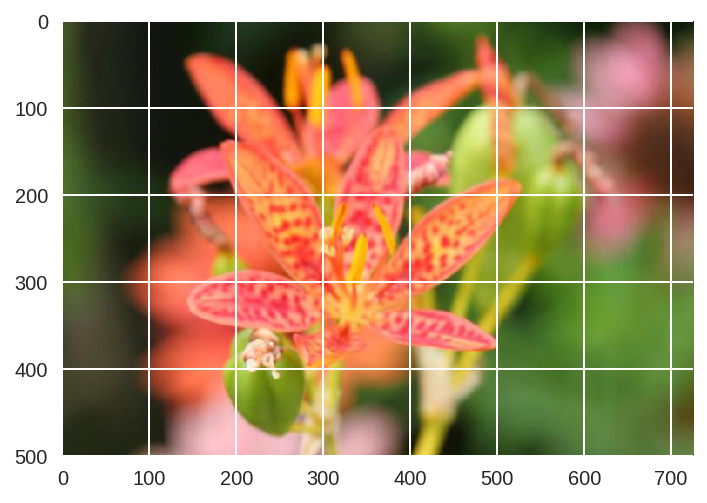

In [31]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    # TODO: Process a PIL image for use in a PyTorch model
    # tensor.numpy().transpose(1, 2, 0)
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                             std=[0.229, 0.224, 0.225])
    ])
    image = preprocess(image)
    return image
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax
with Image.open('flower_data/valid/102/image_08006.jpg') as image:
    plt.imshow(image)
model.class_to_idx = image_datasets['train'].class_to_idx

In [0]:
def predict2(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # TODO: Implement the code to predict the class from an image file
    img = Image.open(image_path)
    img = process_image(img)
    
    # Convert 2D image to 1D vector
    img = np.expand_dims(img, 0)
    
    
    img = torch.from_numpy(img)
    
    model.eval()
    inputs = Variable(img).to(device)
    logits = model.forward(inputs)
    
    ps = F.softmax(logits,dim=1)
    topk = ps.cpu().topk(topk)
    
    return (e.data.numpy().squeeze().tolist() for e in topk)

In [0]:
img_path = 'flower_data/valid/18/image_04252.jpg'
probs, classes = predict2(img_path, model.to(device))
print(probs)
print(classes)
flower_names = [cat_to_name[class_names[e]] for e in classes]
print(flower_names)

[0.8524734377861023, 0.04132053628563881, 0.031449515372514725, 0.024977345019578934, 0.011811628006398678]
[12, 26, 72, 83, 84]
['peruvian lily', 'sweet william', 'azalea', 'clematis', 'hibiscus']


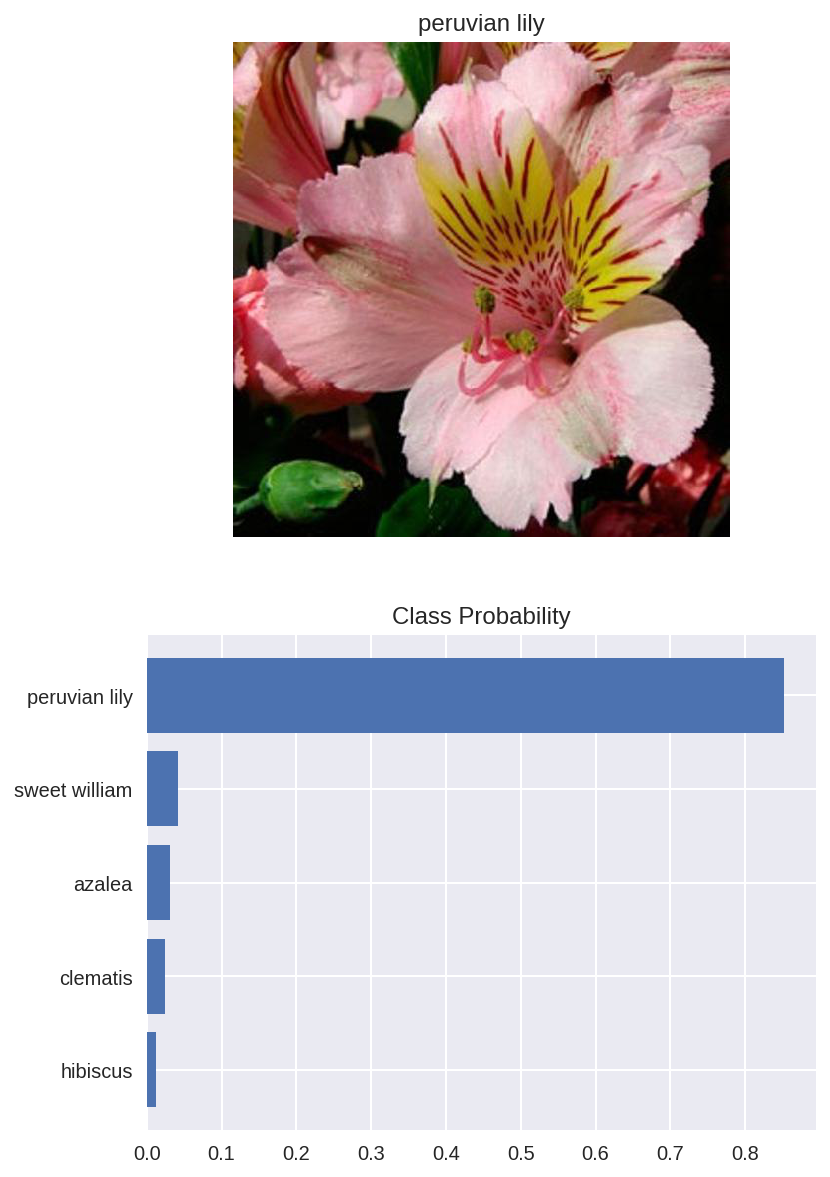

In [0]:
def view_classify(img_path, prob, classes, mapping):
    ''' Function for viewing an image and it's predicted classes.
    '''
    image = Image.open(img_path)
    fig, (ax1, ax2) = plt.subplots(figsize=(6,10), ncols=1, nrows=2)
    flower_name = mapping[img_path.split('/')[-2]]
    ax1.set_title(flower_name)
    ax1.imshow(image)
    ax1.axis('off')
    
    y_pos = np.arange(len(prob))
    ax2.barh(y_pos, prob, align='center')
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels(flower_names)
    ax2.invert_yaxis()  # labels read top-to-bottom
    ax2.set_title('Class Probability')
view_classify(img_path, probs, classes, cat_to_name)